In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import datetime
from power_perceiver.load_raw.data_sources.raw_satellite_data_source import RawSatelliteDataSource
from power_perceiver.load_raw.data_sources.raw_gsp_data_source import RawGSPDataSource
from power_perceiver.load_raw.data_sources.raw_pv_data_source import RawPVDataSource
from power_perceiver.load_raw.raw_dataset import RawDataset
from power_perceiver.transforms.pv import PVPowerRollingWindow

import torch

from power_perceiver.consts import BatchKey
import pandas as pd
import matplotlib.dates as mdates

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]


In [3]:
data_source_kwargs = dict(
    start_date = "2020-01-01",
    end_date = "2020-12-31",
    history_duration = datetime.timedelta(hours=1),
    forecast_duration = datetime.timedelta(hours=2),
)

sat_data_source = RawSatelliteDataSource(
    zarr_path="/media/jack/wd_18tb/data/ocf/satellite/v3/eumetsat_seviri_hrv_uk.zarr",
    roi_height_pixels=128,
    roi_width_pixels=256,
    **data_source_kwargs
)

In [4]:
PV_METADATA_FILENAME = "~/data/PV/Passiv/ocf_formatted/v0/system_metadata_OCF_ONLY.csv"
PV_POWER_FILENAME = "~/data/PV/Passiv/ocf_formatted/v0/passiv.netcdf"
N_PV_SYSTEMS_PER_EXAMPLE = 8

pv_data_source = RawPVDataSource(
    pv_power_filename=PV_POWER_FILENAME,
    pv_metadata_filename=PV_METADATA_FILENAME,
    roi_height_meters=96_000,
    roi_width_meters=96_000,
    n_pv_systems_per_example=N_PV_SYSTEMS_PER_EXAMPLE,
    transforms=[PVPowerRollingWindow(expect_dataset=False)],
    **data_source_kwargs
)

In [5]:
gsp_data_source = RawGSPDataSource(
    gsp_pv_power_zarr_path="~/data/PV/GSP/v3/pv_gsp.zarr",
    gsp_id_to_region_id_filename="~/data/PV/GSP/eso_metadata.csv",
    sheffield_solar_region_path="~/data/PV/GSP/gsp_shape",
    **data_source_kwargs
)

In [6]:
from copy import deepcopy


from power_perceiver.np_batch_processor.encode_space_time import EncodeSpaceTime
from power_perceiver.np_batch_processor.sun_position import SunPosition
from power_perceiver.np_batch_processor.topography import Topography


raw_dataset = RawDataset(
    data_source_combos=dict(
        sat_only=(sat_data_source,),
        gsp_pv_sat=(gsp_data_source, pv_data_source, deepcopy(sat_data_source)),
    ),
    min_duration_to_load_per_epoch=datetime.timedelta(hours=20),
    n_examples_per_batch=4,
    n_batches_per_epoch=16,
    np_batch_processors=[
        EncodeSpaceTime(),
        SunPosition(t0_timestep_idx=12),
        Topography("/home/jack/europe_dem_2km_osgb.tif"),
    ]
)

# TODO: Test appropriate batch processors :)

/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/pyresample/image.py:59: FutureWarning: Usage of ImageContainer is deprecated, please use NumpyResamplerBilinear class instead
  warnings.warn(
/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-packages/pyproj/crs/crs.py:1282: UserWarning: You will likely lose important projection information when converting to a PROJ string from another format. See: https://proj.org/faq.html#what-is-the-best-format-for-describing-coordinate-reference-systems
  proj = self._crs.to_proj4(version=version)
/home/jack/miniconda3/envs/power_perceiver/lib/python3.10/site-

In [7]:
%%time
raw_dataset.per_worker_init(worker_id=0)

CPU times: user 8.86 s, sys: 39.6 ms, total: 8.9 s
Wall time: 8.91 s


In [8]:
data_loader = torch.utils.data.DataLoader(
    raw_dataset,
    batch_size=None,
)

In [9]:
%%time
for np_batch in data_loader:
    pass

/home/jack/dev/ocf/power_perceiver/power_perceiver/np_batch_processor/encode_space_time.py:208: RuntimeWarning: All-NaN slice encountered
  mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
/home/jack/dev/ocf/power_perceiver/power_perceiver/np_batch_processor/encode_space_time.py:208: RuntimeWarning: All-NaN slice encountered
  mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
/home/jack/dev/ocf/power_perceiver/power_perceiver/np_batch_processor/encode_space_time.py:208: RuntimeWarning: All-NaN slice encountered
  mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
/home/jack/dev/ocf/power_perceiver/power_perceiver/np_batch_processor/encode_space_time.py:208: RuntimeWarning: All-NaN slice encountered
  mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
/home/jack/dev/ocf/power_perceiver/power_perceiver/np_batch_processor/encode_space_time.py:208: RuntimeWarning: All-NaN slice encountered
  mins[:, modality_i] = np.nanmin(coord_data_array, axis=1)
/home/jack

CPU times: user 4min 5s, sys: 7.36 s, total: 4min 13s
Wall time: 53.2 s


In [10]:
np_batch.keys()

dict_keys([<BatchKey.hrvsatellite: 1>, <BatchKey.hrvsatellite_time_utc: 6>, <BatchKey.hrvsatellite_y_osgb: 2>, <BatchKey.hrvsatellite_x_osgb: 3>, <BatchKey.hrvsatellite_y_geostationary: 4>, <BatchKey.hrvsatellite_x_geostationary: 5>, <BatchKey.gsp: 22>, <BatchKey.gsp_id: 23>, <BatchKey.gsp_time_utc: 26>, <BatchKey.gsp_y_osgb: 24>, <BatchKey.gsp_x_osgb: 25>, <BatchKey.pv: 11>, <BatchKey.pv_system_row_number: 12>, <BatchKey.pv_id: 13>, <BatchKey.pv_capacity_wp: 14>, <BatchKey.pv_time_utc: 18>, <BatchKey.pv_x_osgb: 17>, <BatchKey.pv_y_osgb: 16>, <BatchKey.hrvsatellite_x_osgb_fourier: 9>, <BatchKey.gsp_x_osgb_fourier: 28>, <BatchKey.pv_x_osgb_fourier: 20>, <BatchKey.hrvsatellite_y_osgb_fourier: 8>, <BatchKey.gsp_y_osgb_fourier: 27>, <BatchKey.pv_y_osgb_fourier: 19>, <BatchKey.hrvsatellite_time_utc_fourier: 10>, <BatchKey.gsp_time_utc_fourier: 29>, <BatchKey.pv_time_utc_fourier: 21>, <BatchKey.solar_azimuth_at_t0: 35>, <BatchKey.solar_elevation_at_t0: 36>, <BatchKey.hrvsatellite_surface_hei

In [11]:
np_batch[BatchKey.hrvsatellite_time_utc].shape

torch.Size([4, 37])

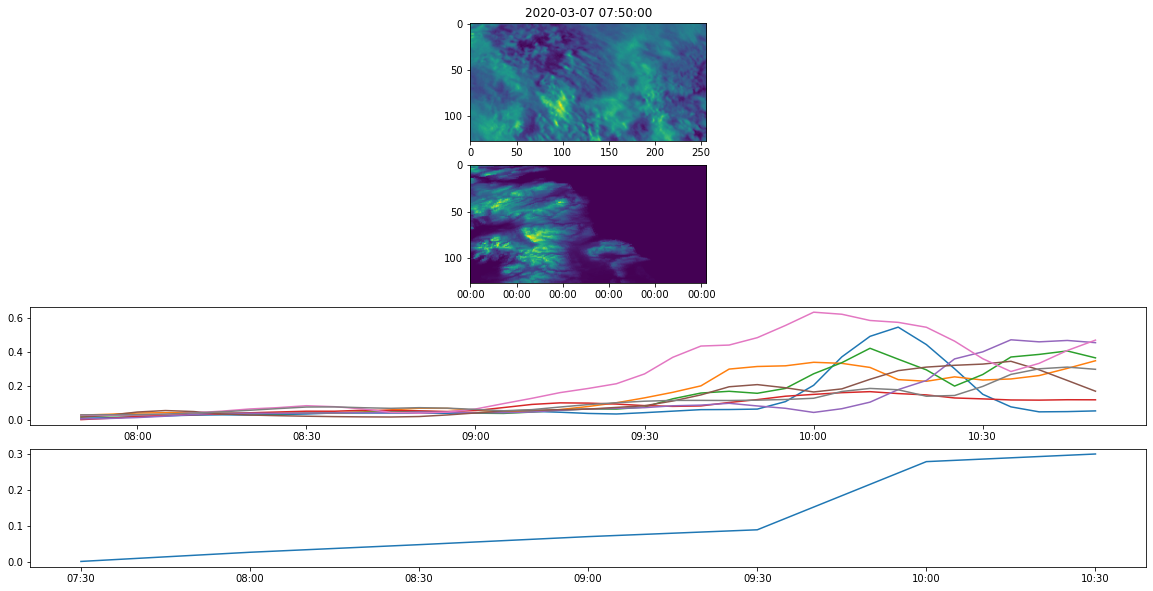

In [17]:
EXAMPLE_IDX = 2
TIME_IDX = 0
CHANNEL_IDX = 0


fig, axes = plt.subplots(nrows=4, figsize=(20, 10))

ax = axes[0]
ax.set_title(pd.to_datetime(np_batch[BatchKey.hrvsatellite_time_utc][EXAMPLE_IDX, TIME_IDX], unit="s"))
ax.imshow(np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, TIME_IDX, CHANNEL_IDX])

ax = axes[1]
ax.imshow(np_batch[BatchKey.hrvsatellite_surface_height][EXAMPLE_IDX])

ax = axes[2]
pv_datetimes = pd.to_datetime(np_batch[BatchKey.pv_time_utc][EXAMPLE_IDX], unit="s")
ax.plot(pv_datetimes, np_batch[BatchKey.pv][EXAMPLE_IDX])

ax = axes[3]
gsp_datetimes = pd.to_datetime(np_batch[BatchKey.gsp_time_utc][EXAMPLE_IDX], unit="s")
ax.plot(gsp_datetimes, np_batch[BatchKey.gsp][EXAMPLE_IDX])

for ax in axes[1:]:
    ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))

In [13]:
import xarray as xr
import cartopy.crs as ccrs

EXAMPLE_IDX = 0
TIME_IDX = 0
CHANNEL_IDX = 0

plt.rcParams['figure.figsize'] = [20, 10]

projection = ccrs.OSGB(approx=False)
ax = plt.axes(projection=projection)
DIMS = ("y", "x")
xr.DataArray(
    np_batch[BatchKey.hrvsatellite][EXAMPLE_IDX, TIME_IDX, CHANNEL_IDX],
    dims=DIMS,
    coords=dict(
        y_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX]),
        x_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX]),
    ),
).plot.pcolormesh(
    ax=ax,
    y="y_osgb",
    x="x_osgb",
    cmap="gray"
    )

ax.coastlines(alpha=0.5, color="black")

# Plot location of PV systems

ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
)

IndexError: array index out of range

<Figure size 1440x720 with 2 Axes>

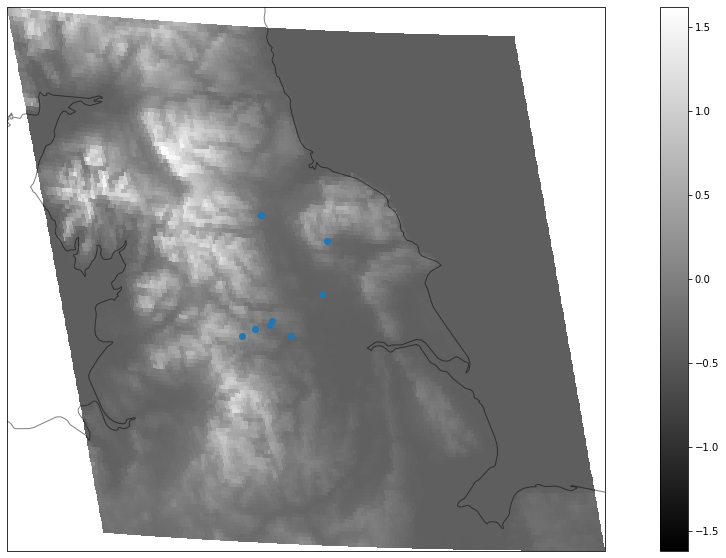

In [ ]:

plt.rcParams['figure.figsize'] = [20, 10]

projection = ccrs.OSGB(approx=False)
ax = plt.axes(projection=projection)
DIMS = ("y", "x")
xr.DataArray(
    np_batch[BatchKey.hrvsatellite_surface_height][EXAMPLE_IDX],
    dims=DIMS,
    coords=dict(
        y_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_y_osgb][EXAMPLE_IDX]),
        x_osgb=(DIMS, np_batch[BatchKey.hrvsatellite_x_osgb][EXAMPLE_IDX]),
    ),
).plot.pcolormesh(
    ax=ax,
    y="y_osgb",
    x="x_osgb",
    cmap="gray"
    )

ax.coastlines(alpha=0.5, color="black")

# Plot location of PV systems

ax.scatter(
    x=np_batch[BatchKey.pv_x_osgb][EXAMPLE_IDX],
    y=np_batch[BatchKey.pv_y_osgb][EXAMPLE_IDX],
)

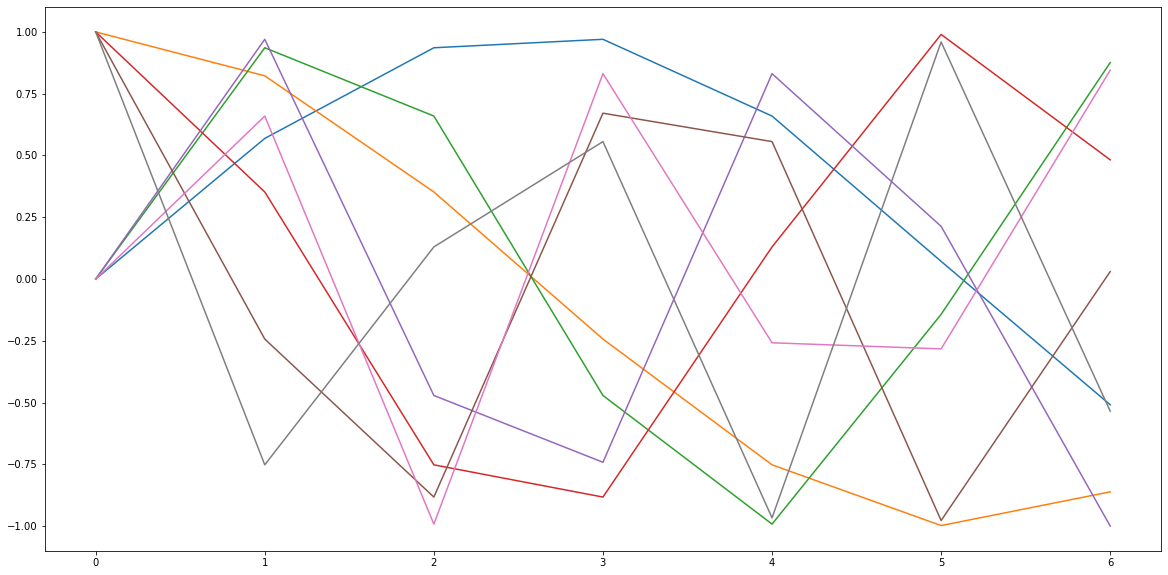

In [ ]:
plt.plot(np_batch[BatchKey.gsp_time_utc_fourier][0])

In [ ]:
np_batch[BatchKey.hrvsatellite_surface_height][0]

tensor([[ 0.6449,  0.6449,  0.6449,  ..., -0.4215, -0.4215, -0.4215],
        [ 0.5607,  0.5607,  0.7403,  ..., -0.4215, -0.4215, -0.4215],
        [ 0.2380,  0.2380,  0.5102,  ..., -0.4215, -0.4215, -0.4215],
        ...,
        [-0.1802, -0.1802, -0.1353,  ..., -0.3177, -0.3598, -0.3598],
        [-0.1661, -0.1661, -0.1661,  ..., -0.3149, -0.3261, -0.3570],
        [-0.2082, -0.2082, -0.2082,  ..., -0.3317, -0.3317, -0.3457]])

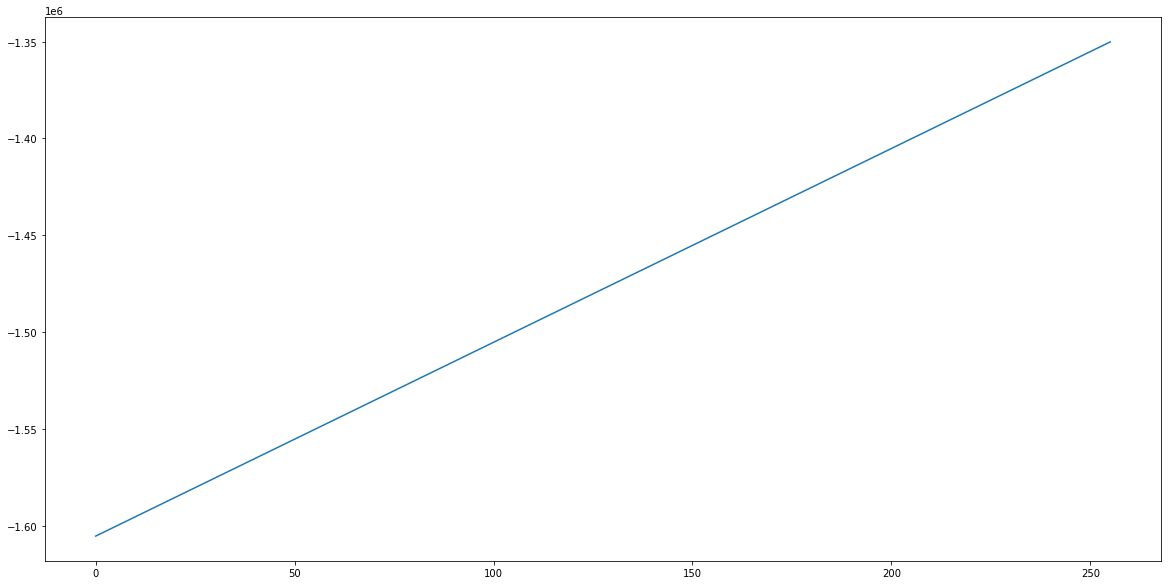

In [ ]:
plt.plot(np_batch[BatchKey.hrvsatellite_x_geostationary][1])


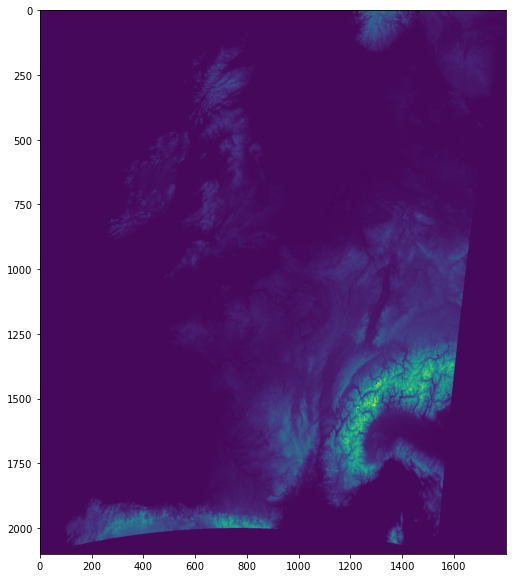

In [ ]:
plt.imshow(raw_dataset.np_batch_processors[2].topo.values)

In [ ]:
raw_dataset.np_batch_processors[2].topo.sel(
    y=slice(
        np_batch[BatchKey.hrvsatellite_y_geostationary][EXAMPLE_IDX, 0],
        np_batch[BatchKey.hrvsatellite_y_geostationary][EXAMPLE_IDX, -1],
        
    ),
    x=slice(
        np_batch[BatchKey.hrvsatellite_x_geostationary][EXAMPLE_IDX, 0],
        np_batch[BatchKey.hrvsatellite_x_geostationary][EXAMPLE_IDX, -1],
        
    ),
)

<xarray.DataArray (y: 273, x: 234)>
array([[380., 380., 418., ...,   0.,   0.,   0.],
       [380., 418., 418., ...,   0.,   0.,   0.],
       [350., 414., 414., ...,   0.,   0.,   0.],
       ...,
       [ 91.,  91.,  97., ...,  38.,  34.,  23.],
       [ 91.,  91.,  97., ...,  34.,  34.,  23.],
       [ 76.,  76.,  96., ...,  32.,  32.,  27.]], dtype=float32)
Coordinates:
  * y        (y) float64 4.812e+06 4.811e+06 4.811e+06 ... 4.685e+06 4.685e+06
  * x        (x) float64 -7.764e+05 -7.753e+05 ... -5.238e+05 -5.227e+05

In [ ]:
np_batch[BatchKey.hrvsatellite_x_geostationary][EXAMPLE_IDX, 0]

tensor(-777104.3750)

In [ ]:
np_batch[BatchKey.hrvsatellite_x_geostationary][EXAMPLE_IDX, -1]

tensor(-522070.1250)